In [83]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Loading the dataset
df: DataFrame = pd.read_csv("heart.csv")

In [49]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [50]:
#Checking for any null values
df.isnull().any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

In [51]:
#Basic dataset statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1888.0,54.354343,9.081505,29.0,47.75,55.0,61.0,77.0
sex,1888.0,0.688559,0.463205,0.0,0.00,1.0,1.0,1.0
cp,1888.0,1.279131,1.280877,0.0,0.00,1.0,2.0,4.0
trestbps,1888.0,131.549258,17.556985,94.0,120.00,130.0,140.0,200.0
chol,1888.0,246.855403,51.609329,126.0,211.00,241.0,276.0,564.0
fbs,1888.0,0.148305,0.355496,0.0,0.00,0.0,0.0,1.0
restecg,1888.0,0.597458,0.638820,0.0,0.00,1.0,1.0,2.0
thalach,1888.0,149.424258,23.006153,71.0,133.00,152.0,166.0,202.0
exang,1888.0,0.331568,0.470901,0.0,0.00,0.0,1.0,1.0
oldpeak,1888.0,1.053761,1.161344,0.0,0.00,0.8,1.6,6.2


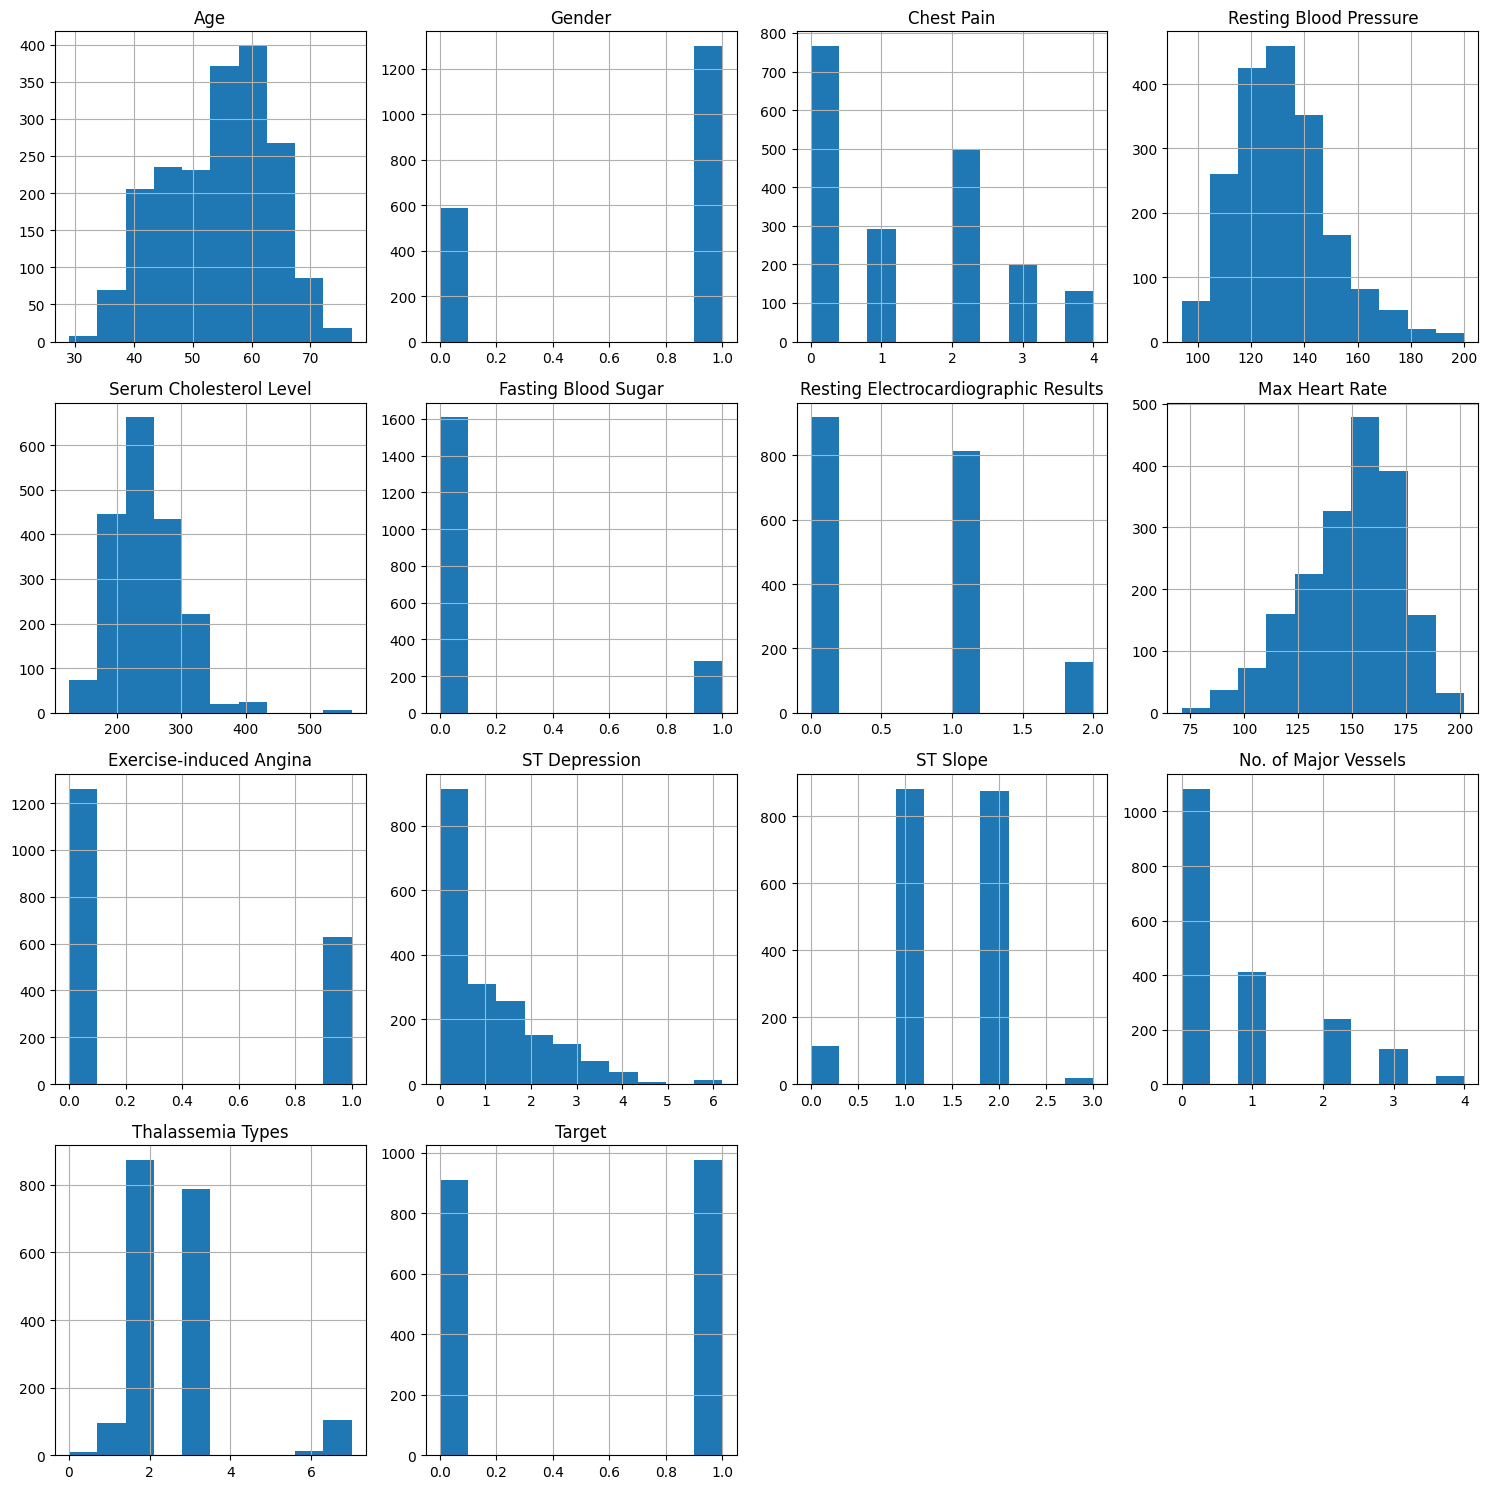

In [ ]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (15, 15)) 
axes = axes.flatten()

titles: list[str] = ["Age", "Gender", "Chest Pain", "Resting Blood Pressure", "Serum Cholesterol Level",
                     "Fasting Blood Sugar", "Resting Electrocardiographic Results", "Max Heart Rate",
                     "Exercise-induced Angina", "ST Depression", "ST Slope", "No. of Major Vessels",
                     "Thalassemia Types", "Target"]

for i, column in enumerate(df.columns):
    df[column].hist(ax=axes[i])
    axes[i].set_title(titles[i])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of Patients')

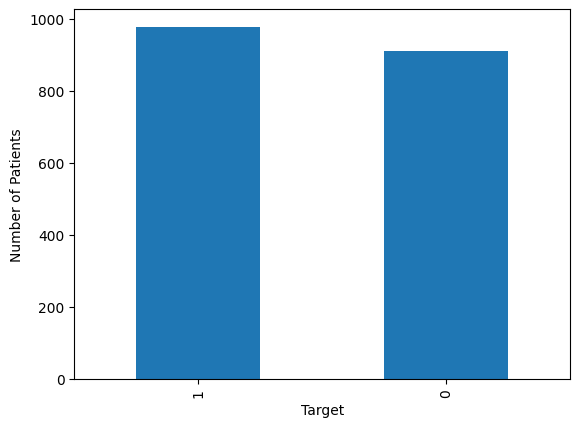

In [54]:
target_count = df['target'].value_counts()
target_count.plot(kind = 'bar')

plt.xlabel('Target')
plt.ylabel('Number of Patients')

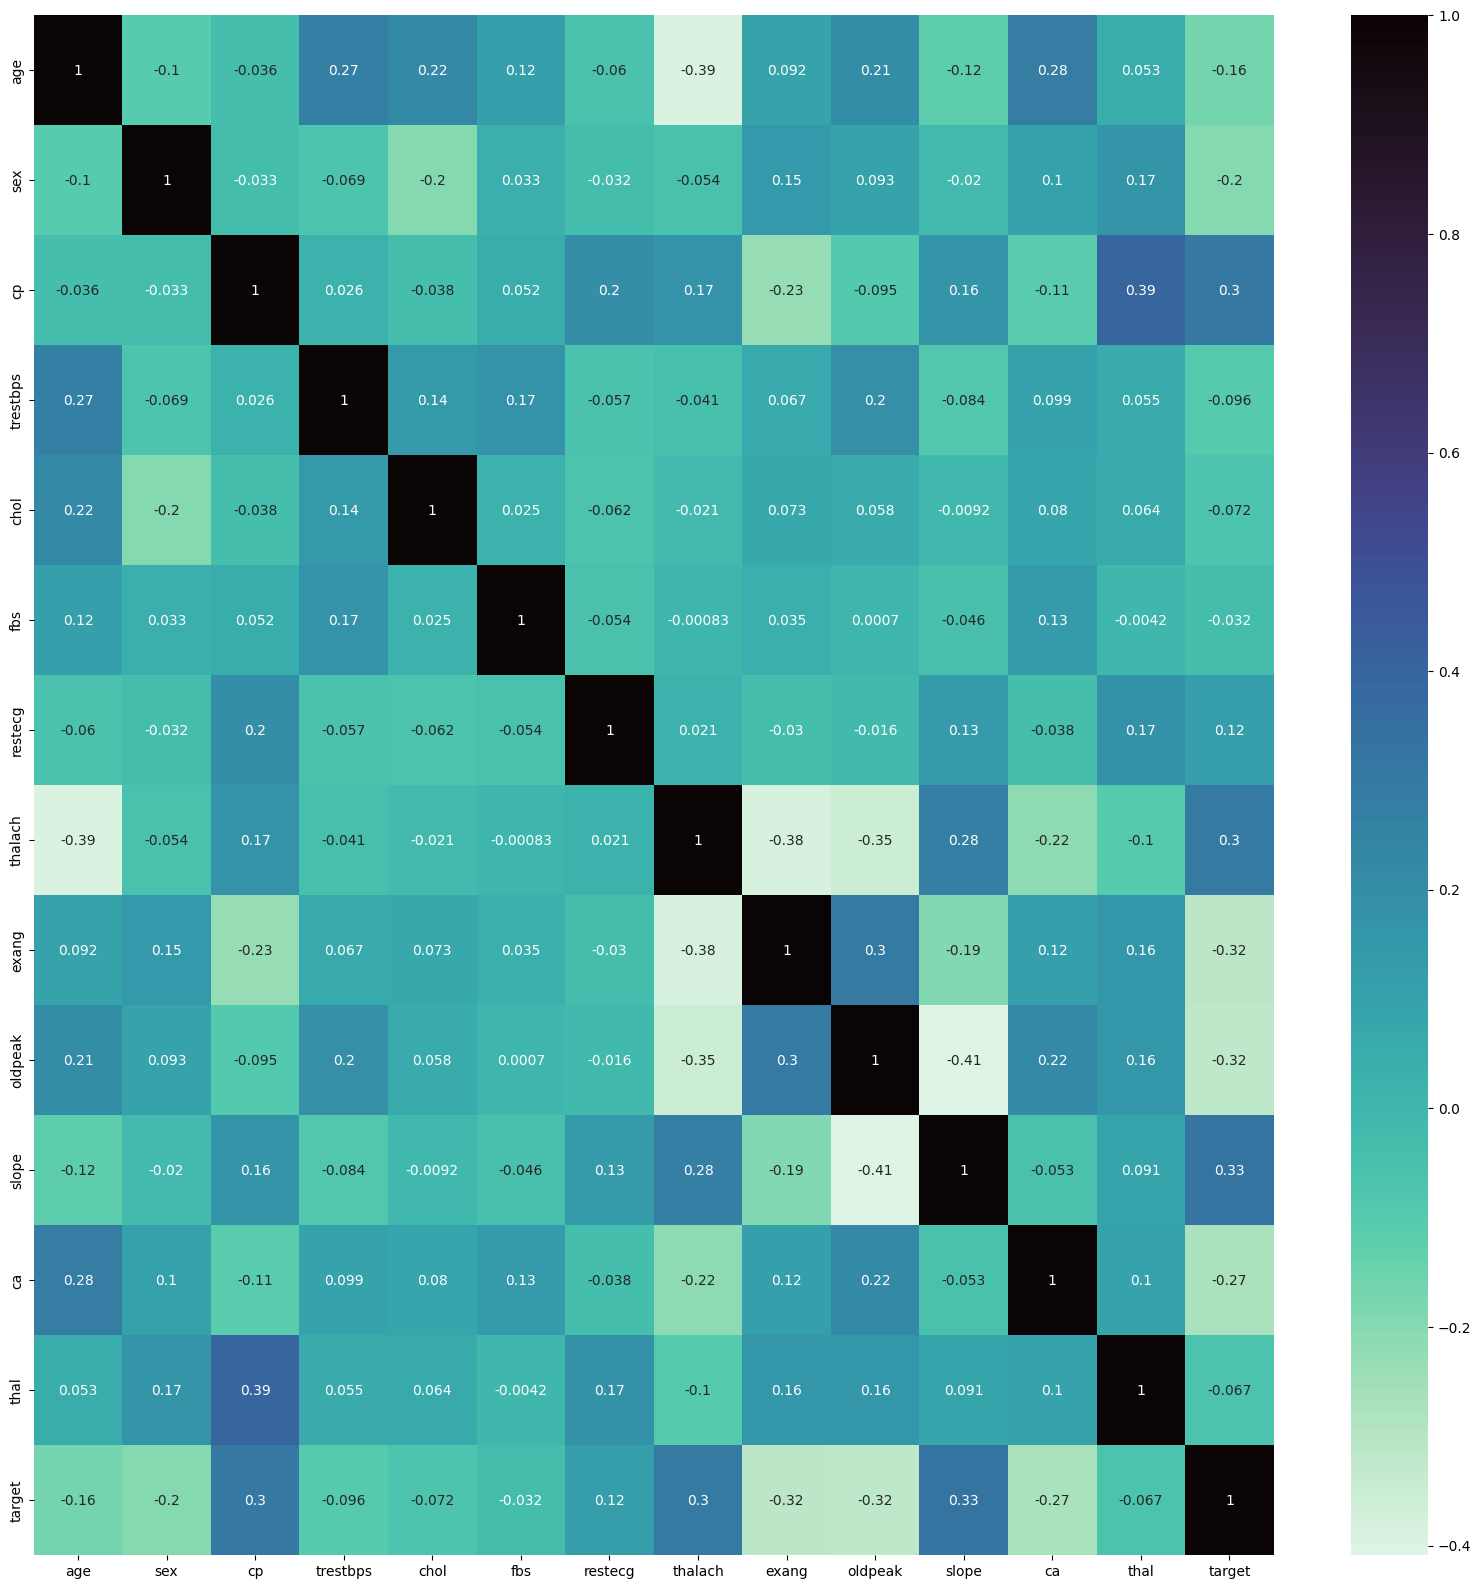

In [55]:
corr_matrix = df.corr()

plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, cmap = 'mako_r', annot = True)
plt.show()

In [56]:
corr_target = abs(corr_matrix['target']).sort_values(ascending= False)
relevant_features = [indices for indices, _ in corr_target[corr_target > 0.1].items()]

dataset = df[relevant_features]
dataset = pd.get_dummies(dataset, columns = ['slope', 'exang', 'cp', 'ca', 'sex', 'restecg'], dtype= int)

corr = abs(dataset.corr()['target'])
rf = [i for i, _ in corr[corr > 0.1].items()]

dataset = dataset[rf]
column_names = dataset.drop('target', axis = 1).columns

dataset

,target,oldpeak,thalach,age,slope_1,slope_2,exang_0,exang_1,cp_0,cp_1,cp_2,cp_4,ca_0,ca_1,ca_2,ca_3,sex_0,sex_1,restecg_0,restecg_1
0,1,2.3,150,63,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0
1,1,3.5,187,37,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1
2,1,1.4,172,41,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0
3,1,0.8,178,56,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,1
4,1,0.6,163,57,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,0,1.9,138,60,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0
1884,0,1.8,120,46,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1
1885,0,0.8,162,59,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1
1886,0,0.0,164,54,0,1,1,0,0,1,0,0,0,1,0,0,0,1,1,0


In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = ['age', 'oldpeak', 'thalach']
dataset[cols] = scaler.fit_transform(dataset[cols])

In [58]:
from sklearn.model_selection import train_test_split

X = dataset.drop('target', axis = 1).values
Y = dataset['target'].values

x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [59]:
def train_baseline_model(model, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):

    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(x_test)
    
    return {
        'classification_report': classification_report(y_test, y_pred),
        'accuracy': f'Baseline Accuracy:  {accuracy_score(y_test, y_pred):.3f}',
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_roc_auc': roc_auc_score(y_test, y_proba),
        'model': model
    }

In [60]:
def train_tuned_model(
                model, 
                param_grid, 
                model_name, 
                x_train = x_train, 
                y_train = y_train, 
                x_test = x_test, 
                y_test = y_test
                ):    
    
    search = GridSearchCV(
        model,
        param_grid,
        cv = 10,
        scoring={
            'accuracy': 'accuracy',
            'roc_auc': 'roc_auc'
        },
        refit='roc_auc',
        n_jobs=-1,
    )

    search.fit(x_train, y_train)
    
    # Get best model predictions
    y_pred = search.predict(x_test)
    
    if hasattr(model, 'predict_proba'):
        y_proba = search.predict_proba(x_test)[:, 1]
    else:  # For SVM without probability=True
        y_proba = search.decision_function(x_test)
        
    return {
        'name': model_name,
        'model': search,
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_roc_auc': roc_auc_score(y_test, y_proba),
        'cv_results': search.cv_results_, 
        'classification_report': classification_report(y_test, y_pred)
    }

In [61]:
def print_baseline_metrics(model) -> None:
    print("Classification Report:\n")
    print(model['classification_report'])
    print(model['accuracy'])

In [62]:
def print_tuned_metrics(model) -> None:
    print(f'Optimal Parameters: {model["model"].best_params_}')
    print(f'\nBest Cross-Validation ROC-AUC: {model["model"].best_score_:.3f}')
    print('\nClassification Report:')
    print(model['classification_report'])
    print(f'Test Accuracy: {model["test_accuracy"]:.3f}')

In [63]:
base_knn = train_baseline_model(KNeighborsClassifier())
print_baseline_metrics(base_knn)

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       213
           1       0.91      0.88      0.89       259

    accuracy                           0.89       472
   macro avg       0.88      0.89      0.88       472
weighted avg       0.89      0.89      0.89       472

Baseline Accuracy:  0.886


In [64]:
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Power parameter for Minkowski
}

knn_model = train_tuned_model(KNeighborsClassifier(), param_grid, "KNN")
print_tuned_metrics(knn_model)

Optimal Parameters: {'metric': 'manhattan', 'n_neighbors': 21, 'p': 1, 'weights': 'distance'}

Best Cross-Validation ROC-AUC: 0.990

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       213
           1       0.94      0.92      0.93       259

    accuracy                           0.92       472
   macro avg       0.92      0.92      0.92       472
weighted avg       0.92      0.92      0.92       472

Test Accuracy: 0.922


c:\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [65]:
base_rf = train_baseline_model(RandomForestClassifier())
print_baseline_metrics(base_rf)

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       213
           1       0.98      0.97      0.97       259

    accuracy                           0.97       472
   macro avg       0.97      0.97      0.97       472
weighted avg       0.97      0.97      0.97       472

Baseline Accuracy:  0.970


Optimal Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Best Cross-Validation ROC-AUC: 0.996

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       213
           1       0.98      0.95      0.96       259

    accuracy                           0.96       472
   macro avg       0.96      0.96      0.96       472
weighted avg       0.96      0.96      0.96       472

Test Accuracy: 0.962


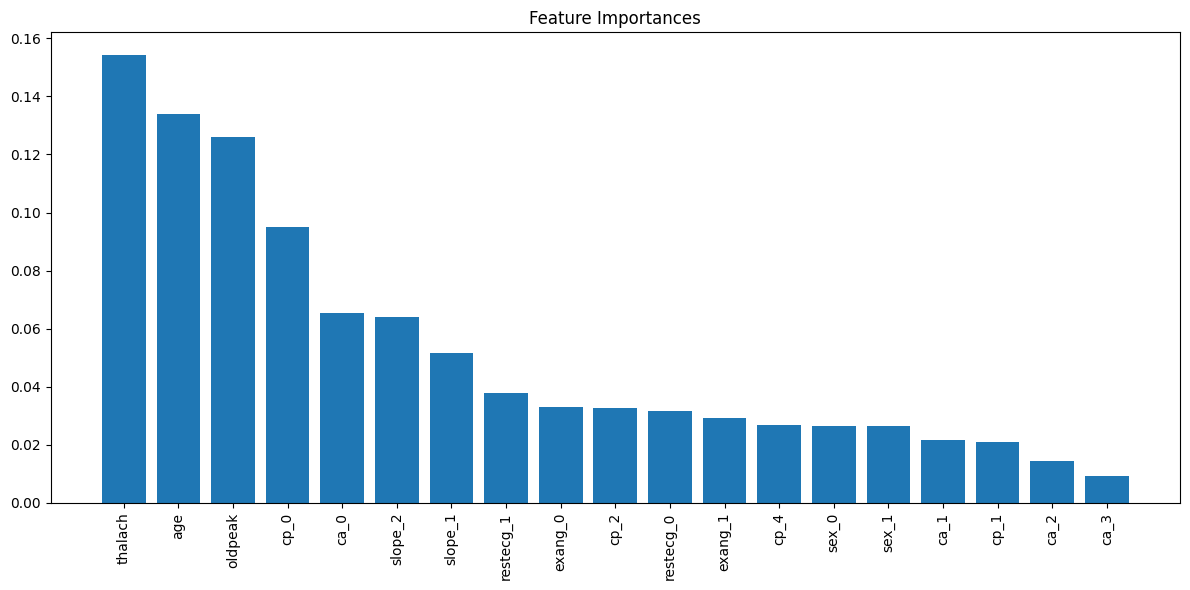

In [66]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5],
    'class_weight': ['balanced'],
    'bootstrap': [True]
}

rf_model = train_tuned_model(RandomForestClassifier(), param_grid, "Random Forest")
print_tuned_metrics(rf_model)

importances = rf_model["model"].best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), column_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [67]:
from sklearn.svm import SVC

base_svm = train_baseline_model(SVC())
print_baseline_metrics(base_svm)

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       213
           1       0.87      0.86      0.87       259

    accuracy                           0.85       472
   macro avg       0.85      0.85      0.85       472
weighted avg       0.85      0.85      0.85       472

Baseline Accuracy:  0.854


In [68]:
param_grid = [
    {'kernel': ['linear'],
     'C': [0.1, 1, 10, 100]},
     
    {'kernel': ['rbf'],
     'C': [0.1, 1, 10, 100],
     'gamma': ['scale', 'auto', 0.1, 1, 10]},
     
    {'kernel': ['poly'],
     'C': [0.1, 1, 10],
     'degree': [2, 3, 4],
     'gamma': ['scale', 'auto']}
]

svm_model = train_tuned_model(SVC(), param_grid, "SVM")
print_tuned_metrics(svm_model)

Optimal Parameters: {'C': 10, 'gamma': 10, 'kernel': 'rbf'}

Best Cross-Validation ROC-AUC: 0.994

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       213
           1       1.00      0.86      0.92       259

    accuracy                           0.92       472
   macro avg       0.93      0.93      0.92       472
weighted avg       0.93      0.92      0.92       472

Test Accuracy: 0.922


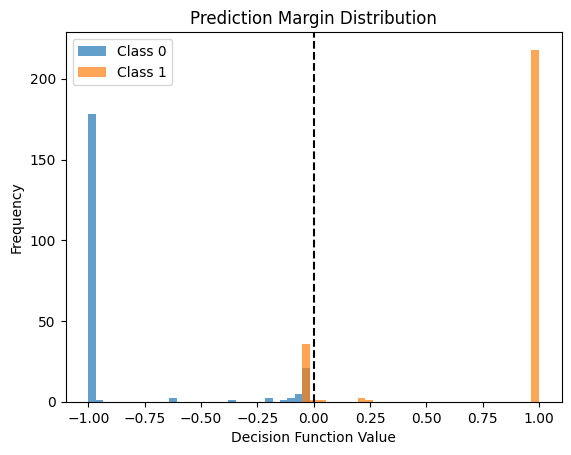

In [69]:
decision_values = svm_model["model"].decision_function(x_test)

plt.hist(decision_values[y_test == 0], 
         bins=30, 
         alpha=0.7, 
         label='Class 0')
plt.hist(decision_values[y_test == 1], 
         bins=30, 
         alpha=0.7, 
         label='Class 1')
plt.axvline(0, color='black', linestyle='--')
plt.title("Prediction Margin Distribution")
plt.xlabel("Decision Function Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [70]:
from sklearn.linear_model import LogisticRegression

base_lr = train_baseline_model(LogisticRegression(max_iter = 1000))
print_baseline_metrics(base_lr)

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       213
           1       0.83      0.75      0.79       259

    accuracy                           0.78       472
   macro avg       0.78      0.78      0.78       472
weighted avg       0.78      0.78      0.78       472

Baseline Accuracy:  0.778


In [71]:
param_grid = [
    {
        'penalty': ['l1'],
        'C': np.logspace(-3, 3, 7),
        'solver': ['liblinear', 'saga'],
    },
    
    {
        'penalty': ['l2'],
        'C': np.logspace(-3, 3, 7),
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    },
    
    {
        'penalty': ['elasticnet'],
        'C': np.logspace(-3, 3, 7),
        'solver': ['saga'],
        'l1_ratio': [0, 0.3, 0.5, 0.7, 1],
    }
]

lr_model = train_tuned_model(LogisticRegression(), param_grid, "Logistic Regression")
print_tuned_metrics(lr_model)

Optimal Parameters: {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}

Best Cross-Validation ROC-AUC: 0.857

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       213
           1       0.82      0.73      0.78       259

    accuracy                           0.77       472
   macro avg       0.77      0.77      0.77       472
weighted avg       0.77      0.77      0.77       472

Test Accuracy: 0.767


In [74]:
def plot_roc_curves(models, model_names, x_test, y_test):
    plt.figure(figsize=(10, 8))
    
    # Plot diagonal line for random classifier
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    
    # Initialize dictionary to store AUC scores
    auc_scores = {}
    
    for model, name in zip(models, model_names):

        model = model["model"]
        # Get probability estimates or decision function scores
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(x_test)[:, 1]
        else:  # For SVM without probability=True
            y_proba = model.decision_function(x_test)
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        auc_scores[name] = auc
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
    
    # Format plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    return auc_scores

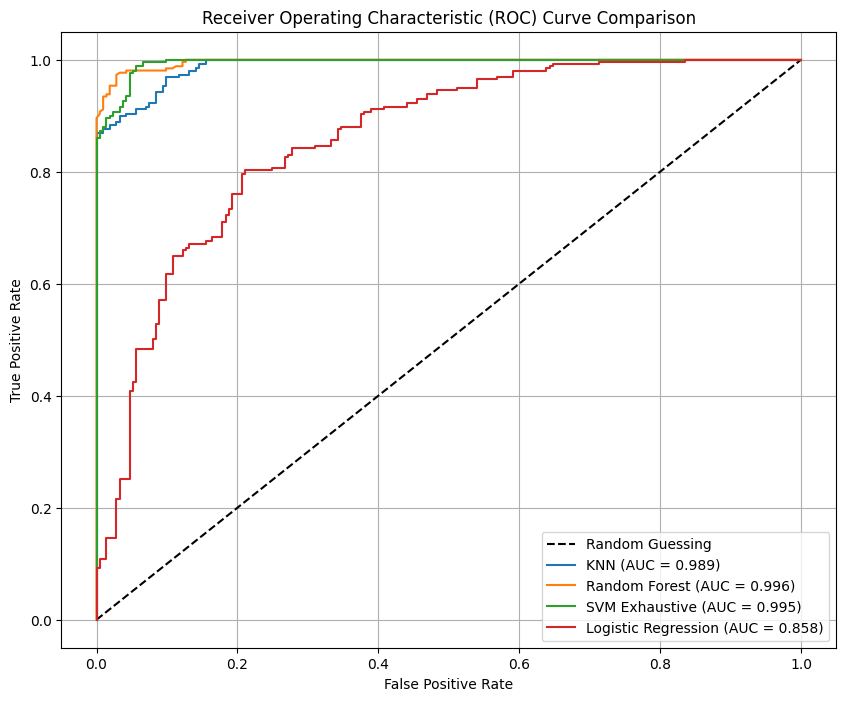

In [76]:
base_models = [base_knn, base_rf, base_svm, base_lr]
tuned_models = [knn_model, rf_model, svm_model, lr_model]
model_names = ['KNN', 'Random Forest', 'SVM Exhaustive', 'Logistic Regression']

# Generate ROC curves and get AUC scores
auc_values = plot_roc_curves(tuned_models, model_names, x_test, y_test) 

In [ ]:
def create_comparison_table(model_names, base_models, tuned_models):
    comparison_data = []
    
    for name, base_model, tuned_model in zip(model_names, base_models, tuned_models):

        comparison_data.append({
            'Model': name,
            'Baseline Accuracy': base_model['test_accuracy'],
            'Tuned Accuracy': tuned_model['test_accuracy'],
            'Accuracy Δ': tuned_model['test_accuracy'] - base_model['test_accuracy'],
            'Baseline ROC-AUC': base_model['test_roc_auc'],
            'Tuned ROC-AUC': tuned_model['test_roc_auc'],
            'ROC-AUC Δ': tuned_model['test_roc_auc'] - base_model['test_roc_auc']
        })
    
    return pd.DataFrame(comparison_data)

In [82]:
comparison_table = create_comparison_table(model_names, base_models, tuned_models)
display(comparison_table)

,Model,Baseline Accuracy,Tuned Accuracy,Accuracy Δ,Baseline ROC-AUC,Tuned ROC-AUC,ROC-AUC Δ
0,KNN,0.885593,0.921610,0.036017,0.948982,0.989269,0.040287
1,Random Forest,0.970339,0.961864,-0.008475,0.996094,0.996311,0.000218
2,SVM Exhaustive,0.853814,0.921610,0.067797,0.932441,0.994870,0.062429
3,Logistic Regression,0.777542,0.766949,-0.010593,0.859173,0.857632,-0.001541
